# Another regression tree with different variables from data

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [18]:
wth = pd.read_csv("weatherHistory.csv")
wth.dropna(inplace=True)
wth.drop_duplicates(inplace=True)
dates = pd.DataFrame(wth["Formatted Date"].apply(lambda x: x[:10]).value_counts())
down_index = dates.loc[dates["Formatted Date"] < 24].index
for i in down_index:
    wth = wth[~(wth["Formatted Date"].str.startswith(i))]
upper_index = dates.loc[dates["Formatted Date"] > 24].index
for i in upper_index:
    wth = wth[~(wth["Formatted Date"].str.startswith(i))]


In [3]:
wth.drop("Loud Cover", axis=1, inplace=True)
wth.drop("Apparent Temperature (C)", axis=1, inplace=True)
wth.drop("Daily Summary", axis=1, inplace=True)
wth.drop(wth[wth["Pressure (millibars)"] < 1].index, inplace=True)


for i in wth["Summary"].value_counts()[5:].index:
    wth = wth[(~(wth["Summary"] == i))]
wth["Summary"].value_counts()

wth["hour"] = wth["Formatted Date"].apply(lambda x: x[10:13])
wth["hour"] = wth["hour"].astype(int)
wth["Month"] = wth["Formatted Date"].apply(lambda x: x[5:7])
wth["Month"] = wth["Month"].astype(int)
wth["DayOfYear"] = wth["Formatted Date"].apply(lambda x: x[:10])
wth['DayOfYear'] = wth['DayOfYear'].astype('datetime64[ns]')
wth["DayOfYear"] = wth["DayOfYear"].apply(lambda x: x.timetuple().tm_yday)
wth.drop(["Formatted Date", "Wind Speed (km/h)", "Wind Bearing (degrees)"], axis=1, inplace=True)

# Creating model + searching for optimal depth value

In [5]:
wth_encoded = pd.get_dummies(wth, columns=["Summary", "Precip Type"])
hyper = pd.DataFrame(columns=["depth", "mse"])

summary_df = pd.DataFrame()
for z in range(30):
    for i in range(1, 70):
        X_train, X_test, y_train, y_test = train_test_split(wth_encoded.drop("Temperature (C)", axis=1), wth_encoded["Temperature (C)"], test_size=0.2)
        regressor = DecisionTreeRegressor(max_depth=i)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        score = regressor.score(X_test, y_test)
        new_row = [i, mse]
        hyper.loc[len(hyper)] = new_row
        summary_df = pd.concat([summary_df, pd.DataFrame({"mse": [mse], "max_depth" : [i]})])

In [6]:
summary_df = summary_df.groupby("max_depth").mean()

<AxesSubplot:xlabel='max_depth', ylabel='mse'>

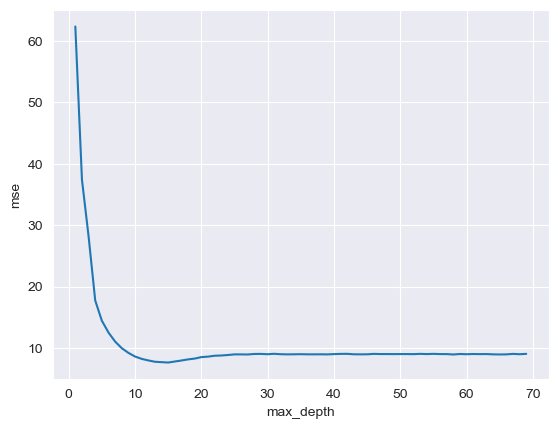

In [7]:
sns.lineplot(data=summary_df, x="max_depth", y="mse")

In [9]:
summary_df.sort_values(by="mse") #depth 15

,mse
max_depth,
15,7.668665
14,7.725967
13,7.792588
16,7.831744
17,7.995305
12,8.010986
18,8.177686
11,8.264123
19,8.307477


# Searching for best max_leaf value

In [10]:
wth_encoded = pd.get_dummies(wth, columns=["Summary", "Precip Type"])
hyper = pd.DataFrame(columns=["max_leaf", "mse", "score"])

summary_df = pd.DataFrame()
for i in range(2, 600, 20):
    X_train, X_test, y_train, y_test = train_test_split(wth_encoded.drop("Temperature (C)", axis=1), wth_encoded["Temperature (C)"], test_size=0.2)
    regressor = DecisionTreeRegressor(max_leaf_nodes=i)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    score = regressor.score(X_test, y_test)
    new_row = [i, mse, score]
    hyper.loc[len(hyper)] = new_row
    summary_df = pd.concat([summary_df, pd.DataFrame({"mse": [mse], "max_leaf_nodes" : [i]})])



<AxesSubplot:xlabel='max_leaf_nodes', ylabel='mse'>

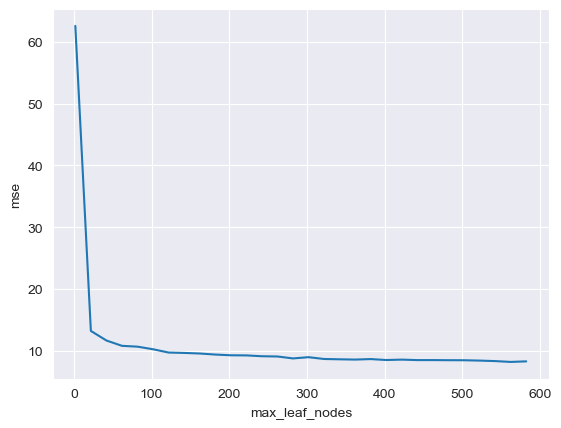

In [11]:
summary_df = summary_df.set_index("max_leaf_nodes")
sns.lineplot(data=summary_df, x="max_leaf_nodes", y="mse")

In [12]:
summary_df.sort_values(by="mse") #562 

,mse
max_leaf_nodes,
562,8.192627
582,8.282826
542,8.327501
522,8.407257
502,8.464252
482,8.470495
442,8.487493
462,8.489100
402,8.500560


In [13]:
print(mse**(1/2)/y_test.mean())

0.24081810828603617


In [14]:

summary_df = pd.DataFrame()
X_train, X_test, y_train, y_test = train_test_split(wth_encoded.drop("Temperature (C)", axis=1), wth_encoded["Temperature (C)"], test_size=0.2)
regressor = DecisionTreeRegressor(max_depth=14, max_leaf_nodes=560)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
score = regressor.score(X_test, y_test)
print(f"MSE: {round(mse, 3)}, MAE: {round(mse**(1/2), 3)}")
print(f"Score: {round(score, 3)}")
print(mse**(1/2)/y_test.mean())

MSE: 8.193, MAE: 2.862
Score: 0.911
0.23905445446961326


In [15]:
print(f"MSE: {round(mse, 3)}, MAE: {round(mse**(1/2), 3)}")
print(f"Score: {round(score, 3)}")
print(mse**(1/2)/y_test.mean())

MSE: 8.193, MAE: 2.862
Score: 0.911
0.23905445446961326


<AxesSubplot:xlabel='Temperature (C)', ylabel='Count'>

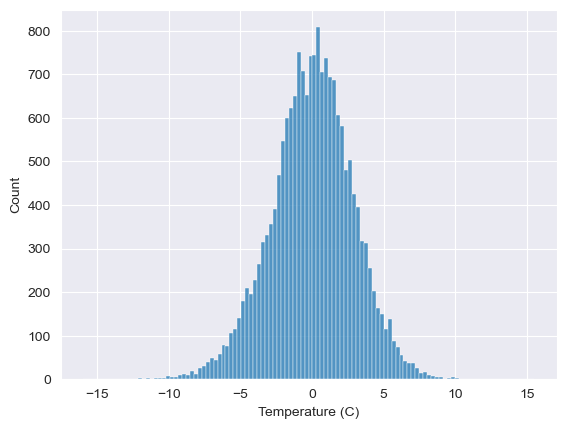

In [16]:
sns.histplot(y_test - y_pred)

<AxesSubplot:xlabel='Temperature (C)'>

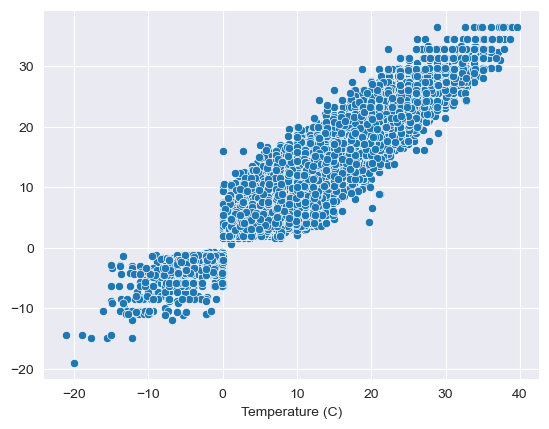

In [17]:
sns.scatterplot(x=y_test, y=y_pred)

# Compared to the previous regression tree this way is more successful